In [3]:
%load_ext autoreload
%autoreload 2

In [96]:
import pandas as pd
import matplotlib
import dataloaders
import torchvision
import torch
import convGRU
import baseline_logistic
import evaluation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


In [91]:
plt.rcParams["figure.figsize"] = (12,10)
sns.set(font_scale = 1.4)

def plot_confusion(confusion):

    ax = sns.heatmap(
        confusion,
        annot=True, 
        fmt = '.1f', 
        square=1, 
        linewidth=1,
        vmin=0.0,
        vmax=100.0,
        xticklabels=['imperv', 'agri', 'forest', 'wetland', 'soil', 'water', 'ice'],
        yticklabels=['imperv', 'agri', 'forest', 'wetland', 'soil', 'water', 'ice']
    )
    for t in ax.texts: t.set_text(t.get_text() + " %")
    ax.invert_xaxis()
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Target')
    plt.yticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees

In [4]:
test_poi_list = [
    "1700_3100_13_13N",
    "2029_3764_13_15N",
    "4426_3835_13_33N",
    "4397_4302_13_33S",
    "5125_4049_13_38N",
    "4768_4131_13_35S"
]

transform = torchvision.transforms.Resize(size=(128, 128))

test_dataloader = dataloaders.SpatiotemporalDataset(
    "../data/processed/npz",
    dims=(1024, 1024),  # Original dims, not post-transformation
    poi_list=test_poi_list,
    n_steps=2,  # start with one prediction (effectively flat CNN)
    cell_width_pct=1,
    labs_as_features=False,
    transform=transform,
    download=False,
    in_memory=True,
)

Baseline Model: Logistic Regression


In [5]:
lreg = baseline_logistic.LogisticRegression(
        input_dim = 4,
        output_dim = 7,
        upsample_dim = 1024,
        cuda_=False
    )
lreg.load_state_dict(torch.load("../output/models/LReg_8step.pt")['model_state_dict'])
lreg.eval()

LogisticRegression(
  (linear): Linear(in_features=4, out_features=7, bias=True)
  (upsampler): Resize(size=(1024, 1024), interpolation=bilinear, max_size=None, antialias=None)
)

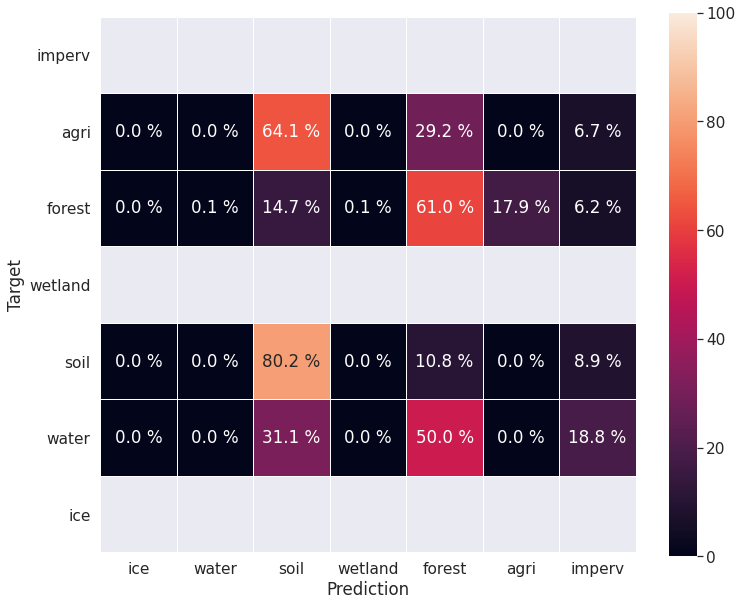

In [92]:
confusion = evaluation.get_confusion(
    model = lreg,
    dataloader=test_dataloader,
    bptt_len=0
)
plot_confusion(confusion)

In [93]:
train_report = pd.read_json('../output/models/LReg_8step.json')

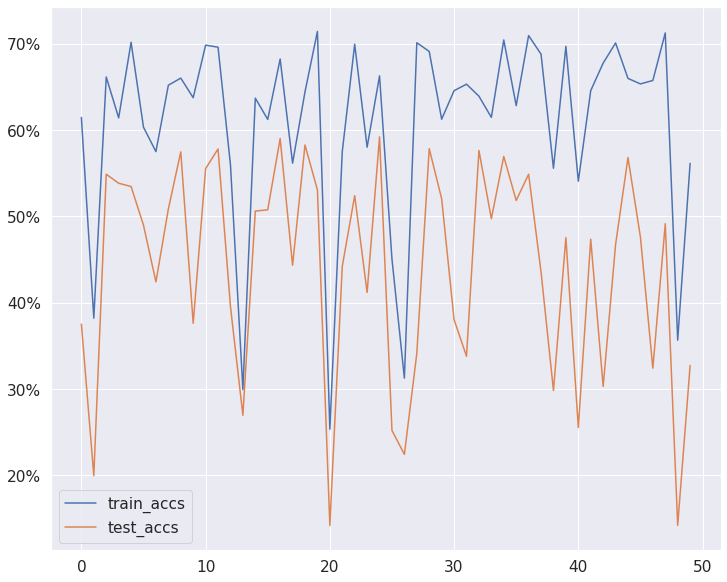

In [98]:
ax = train_report.loc[:,['train_accs','test_accs']].plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

<AxesSubplot:>

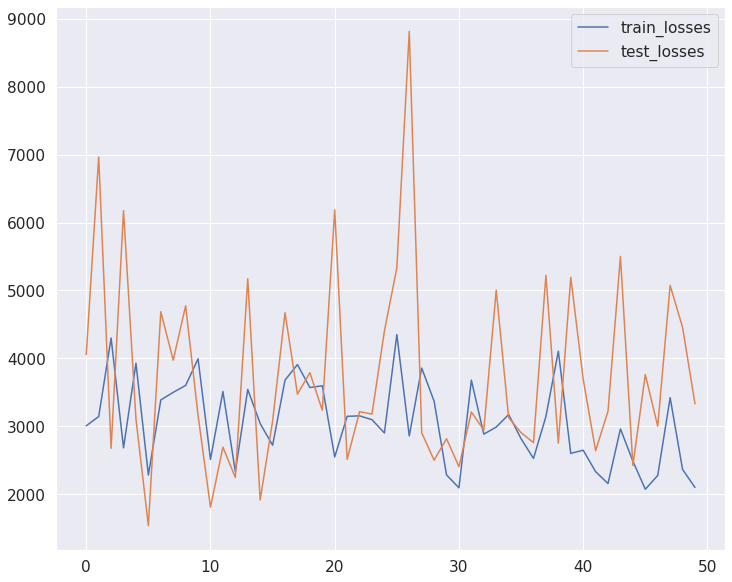

In [99]:
train_report.loc[:,['train_losses','test_losses']].plot()

Model 1: CNN

In [101]:
CNN_mod = convGRU.ConvGRU(
    input_dim=(128, 128),
    output_dim=(1024, 1024),
    num_layers=1,
    input_channels=4,
    hidden_channels=[512],
    n_output_classes=7,
    kernel_size=7,
    batch_first=True,
    conv_padding_mode="replicate",
    bias=True,
    cuda_=False,
)

In [10]:
train_report = pd.read_json('../output/models/CNN_2step.json')

In [104]:
CNN_mod.load_state_dict(
    torch.load(
        "../output/models/CNN_8step.pt",
        map_location=torch.device('cpu')
    )['model_state_dict']
)

<All keys matched successfully>

In [ ]:
confusion = evaluation.get_confusion(
    model = CNN_mod,
    dataloader=test_dataloader,
    bptt_len=0
)
plot_confusion(confusion)

<AxesSubplot:>

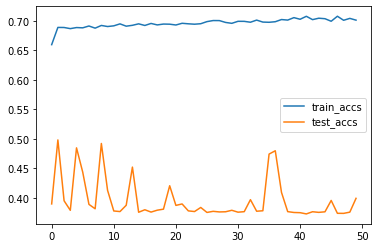

In [11]:
train_report.loc[:,['train_accs','test_accs']].plot()

<AxesSubplot:>

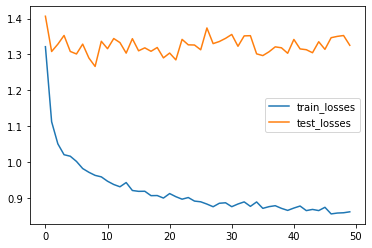

In [12]:
train_report.loc[:,['train_losses','test_losses']].plot()